## Figure 9 -- discovery study

In [1]:
from concurrent.futures import ProcessPoolExecutor
from pathlib import Path
import pickle

import hypney.all as hp
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from scipy import stats
from tqdm import tqdm

import common

'''
# Comment out the line below if you don't have a LaTeX installation
plt.rcParams["text.usetex"] =  True
#'''

/home/peaelle42/miniconda3/envs/py38/lib/python3.8/site-packages/hypney/utils/numba.py:21: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  return numba.jit(f)
/home/peaelle42/miniconda3/envs/py38/lib/python3.8/site-packages/hypney/utils/numba.py:21: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  return numba.jit(f)


'\n# Comment out the line below if you don\'t have a LaTeX installation\nplt.rcParams["text.usetex"] =  True\n#'

## Feldman-cousins intervals

Just another implementation of [ https://arxiv.org/abs/physics/9711021 ]

In [2]:
# Grid of hypotheses: expected signal events
mu = np.concatenate([np.array([0]), np.geomspace(0.1, 200, 10_000)])
confidence_level = 0.9

def fc_limits(mu_bg=0, confidence_level=confidence_level, mu=mu):
    # Total expected events
    mu_tot = mu + mu_bg
    # best-fit total mu
    n = np.arange(stats.poisson(mu.max()).ppf(0.999)).astype(int)
    mu_tot_best = (n - mu_bg).clip(0, None) + mu_bg
    # Make (mu, n) arrays
    o = None
    # Probability of observation (given hypothesis)
    p = stats.poisson(mu_tot[:,o]).pmf(n[o,:])
    # -2 likelihood ratio of observation (given hypothesis)
    t = -2 * ( 
        # Log P(test)
        stats.poisson(mu_tot[:,o]).logpmf(n[o,:]) 
        # Log P(best fit)
        - stats.poisson(mu_tot_best[o,:]).logpmf(n[o,:]) )

    # Build Neyman band for Feldman-Cousins
    excluded = t != t
    for i in range(len(mu)):
        # Arrays to order ns by *descending* t (likely observations LAST)
        # and to undo that order
        order = np.argsort(-t[i])
        undo_order = np.argsort(order)
        # Exclude observations with highest ts and probability summing to <0.1
        excluded[i] = (np.cumsum(p[i][order]) < (1 - confidence_level))[undo_order]
    # Include mus in between included mus (ensure continuous intervals)
    for j in range(len(n)):
        excluded[:,j] = (
            np.minimum.accumulate(excluded[:,j])
            | np.minimum.accumulate(excluded[:,j][::-1])[::-1])
    
    # Convert band to limit lookup arrays for each observed n
    # Upper limit: mu is excluded, but mu just below it (roll
    # forward to align) is allowed. 
    # Argmax picks out the single true value; we already included mus
    # between included mus.
    upper = mu[np.argmax(excluded & np.roll(~excluded, 1, axis=0), axis=0)]
    # Convert band to limit lookup arrays for each observed n
    # Upper limit: mu is excluded, but mu just above it (roll
    # back to align) is allowed. 
    # (Still need argmax: argmin would pick out the first False value.)
    lower = mu[np.argmax(excluded & np.roll(~excluded, -1, axis=0), axis=0)]
    
    # Correct np.roll artifacts
    upper[upper == mu[-1]] = 0   
    lower[lower == mu[-1]] = 0
    
    # Coverage = probability truth is excluded
    # (mu, n arrays inside, then sum over n)
    # TODO: what about < vs <= here? For dense enough mu it shouldn't matter.
    # Let's say we quote closed intervals on mu.
    
    # Actually he shouldn't worry about < vs <=. Definition of coverage is that the 
    # true value of the param lies within [LL, UL], closed interval. 
    # So the lower limit undercovers if mu < LL and 
    # the upper limit undercovers if mu > UL.
    # So he is correct use < instead <= in the following two lines. 
    # Instead of of MC-ing out the coverage, this is like taking expectation 
    # of LL undercovering (mu < LL) and UL undercovering (mu > UL) over the 
    # poisson distribution, because that's the probability of each case occurring 
    # if you were to sample the poisson during the MC-ing process.
    false_lower = np.sum(p * (lower[None,:] > mu[:,None]), axis=1)
    false_upper = np.sum(p * (upper[None,:] < mu[:,None]), axis=1)
    coverage = np.sum(
        p * ((upper[None,:] >= mu[:,None])
             & (lower[None,:] <= mu[:,None])),
        axis=1)   
    
#     # Quantiles to compute for sensitivity 
#     quantiles = stats.norm.cdf([-2, -1, 0, 1, 2])
        
#     # First compute the +-1 sigma observations (for no signal).
#     n_m2, n_m1, n_med, n_p1, n_p2 = [
#         find_quantile(q, mu_bg)
#         for q in quantiles]
    
#     # Convert to quantiles of upper and lower limits
#     def get_index(n_q):
#         return np.argmin(np.abs(n - n_q))
#     u_m2, u_m1, u_med, u_p1, u_p2 = [
#         upper[get_index(n_q)]
#         for n_q in (n_m2, n_m1, n_med, n_p1, n_p2)]
#     l_m2, l_m1, l_med, l_p1, l_p2 = [
#         upper[get_index(n_q)]
#         for n_q in (n_m2, n_m1, n_med, n_p1, n_p2)]
    
#     # Lowest n observed that gives a discovery 
#     # At this n, or higher, the lower limit is > 0
#     n_discovery = n[np.where(lower > 0)[0].min()]

#     # Discovery power for each mu
#     # = fraction of trials that have a nonzero lower limit
#     # Note sf doesn't include p of argument itself, unlike cdf
#     disc_power = stats.poisson(mu_tot).sf(np.round(n_discovery) - 1)

    return dict(
        mu_bg=mu_bg,
        n=n,
        lower=lower,
        upper=upper,
        excluded=excluded,
        
        false_upper=false_upper,
        false_lower=false_lower,
        coverage=coverage,
        
        # Plus/minus 2-1-0 sigma quantiles of n, upper limit, and lower limit
        # n_m2=n_m2, n_m1=n_m1, n_med=n_med, n_p1=n_p1, n_p2=n_p2,
        # u_m2=u_m2, u_m1=u_m1, u_med=u_med, u_p1=u_p1, u_p2=u_p2,
        # l_m2=u_m2, l_m1=u_m1, l_med=u_med, l_p1=u_p1, l_p2=u_p2,
        # n_discovery=n_discovery,
        # disc_power=disc_power
    )

def find_quantile(q, mu_bg):
    """Return the n at the background-only quantile q"""
    return stats.poisson(mu_bg).ppf(q)

To check we didn't mess up: compare the plot below with figure 7 in Feldman&Cousins (p.26). 

There is one difference: the band here steps _in between_ possible values of n, rather than _at_ n values. That's OK, it just makes it unambiguous whether boundary values are included or not. Read off confidence intervals using the red dots at an observed n.

Text(0.5, 1.0, '3 expected background events')

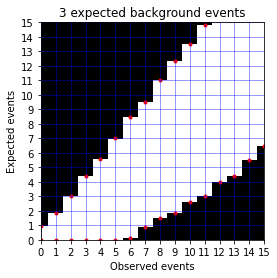

In [3]:
#q = fc_limits(mu_bg=0) # just testing
q = fc_limits(mu_bg=3)

plt.figure(figsize=(4,4))
plt.pcolormesh(q['n'], mu, q['excluded'], shading='nearest', cmap=plt.cm.Greys)

plt.scatter(q['n'], q['upper'], c='r', marker='.')
plt.scatter(q['n'], q['lower'], c='r', marker='.')

plt.xticks(np.arange(16))
plt.yticks(np.arange(16))
plt.xlim(0, 15)
plt.ylim(0, 15)
plt.grid(c='b', alpha=0.5)
plt.ylabel("Expected events")
plt.xlabel("Observed events")
plt.title(f"{q['mu_bg']} expected background events")

(0.0, 10.0)

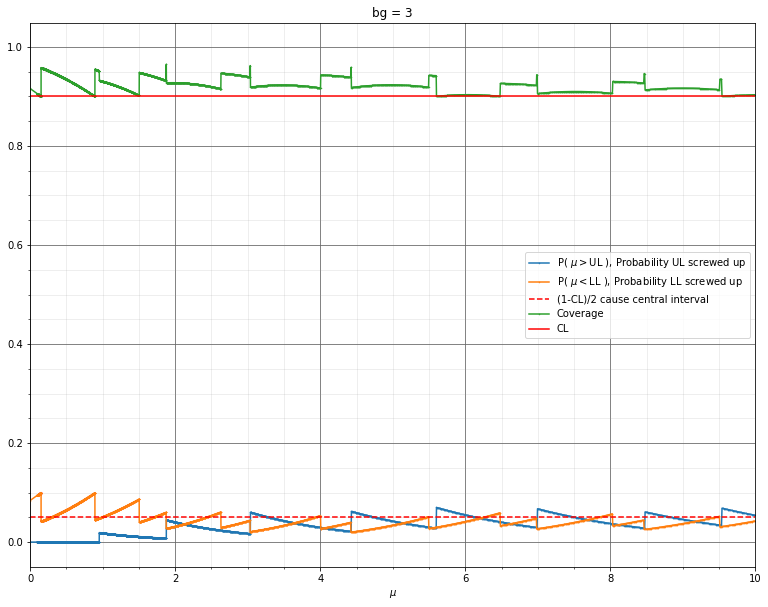

In [4]:
plt.figure(figsize=(13, 10), facecolor='w')

plt.plot(mu, q['false_upper'], '.-', ms=1, label='P( $\mu>$UL ), Probability UL screwed up')
plt.plot(mu, q['false_lower'], '.-', ms=1, label='P( $\mu<$LL ), Probability LL screwed up')
plt.axhline((1-confidence_level)/2., c='r', ls='--', label='(1-CL)/2 cause central interval')

# Checking overall coverage
plt.plot(mu, q['coverage'], '.-', ms=1, label='Coverage')
plt.axhline(confidence_level, c='r', label='CL')

plt.xlabel('$\mu$')
plt.title(f'bg = {q["mu_bg"]}')
plt.minorticks_on()
plt.grid(which='major', color='#666666', linestyle='-')
plt.grid(which='minor', color='#999999', linestyle='-', alpha=0.2)
plt.legend()

plt.xlim(0, 10)

Coverage is a property of the true value of the parameter of interest, $\mu$.

A confidence interval, [LL, UL], of confidence level, CL is said to have exact coverage if the true value of the parameter of interest, $\mu$, lies within the interval [LL, UL], exactly CL% of the times. This means that in (1-CL)% of the times, the following happened:
1. $\mu$ > LL: False exclusion of the true value by the LL (LL screwed up, orange line above), and/or
2. $\mu$ < UL: False exclusion of the true value by the UL (UL screwed up, blue line above)

One can choose how to spread the (1-CL) probability of screwing up across the screwing up of the LL or the UL, but if one were to split ths probability of screwing up evenly across the two cases, then the probability of false exclusion of the true value of the target parameter LL and the probability of the false exclusion of the true value of the target parameter by the UL should both be (1-CL)/2. From the above plot, this is largely the case, but it breaks down for small signal expectation, $\mu\lesssim2$ for this case of background expectation = 3. I.e. the FC interval is not a central interval for small signal expectation, or at least for this case of background expectation = 3 (which is quite low I guess).

It is understandable that the probability of UL screwing up is less than (1-CL)/2, ie, the UL overcovers. And to compensate for this overcovering, the LL undercovers. TBH, not sure if intended.


And compare this with table IV on p. 37:

In [5]:
q['lower'][7], q['upper'][7]

(0.8942356711945959, 9.531591009140486)

Check probability of false upper and lower limits, which we need below. Since Feldman-Cousins intervals are never empty, their sum should equal the total false exclusion probability -- until we get to mus near the end of the considered posible range (mu>>100 here, just adjust linspace above to consider higher ones).

Text(0.5, 1.0, '3 expected background events')

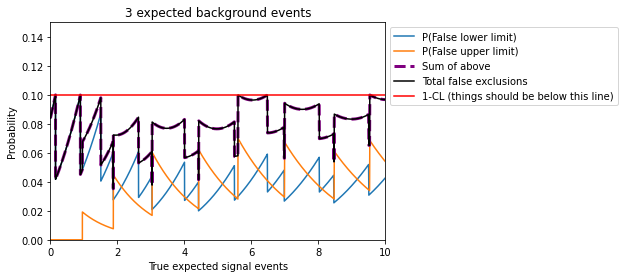

In [6]:
plt.plot(mu, q['false_lower'], 
         label='P(False lower limit)')
plt.plot(mu, q['false_upper'], 
         label='P(False upper limit)')
plt.plot(mu, q['false_upper'] + q['false_lower'],
         label='Sum of above',
         linestyle='--', c='purple', linewidth=3)
plt.plot(mu, 1 - q['coverage'], 
         label='Total false exclusions',
         c='k')
plt.axhline(1-confidence_level, c='r', label='1-CL (things should be below this line)')
plt.legend(loc='upper left', bbox_to_anchor=(1,1))

plt.xlabel("True expected signal events")
plt.xlim(0, 10)

plt.ylabel("Probability")
plt.ylim(0, 0.15)

plt.title(f"{q['mu_bg']} expected background events")

## Example experiment with a background-free core

In [7]:
# core region is [0, 0.3]
f_core = 0.3
#f_core = 0.8

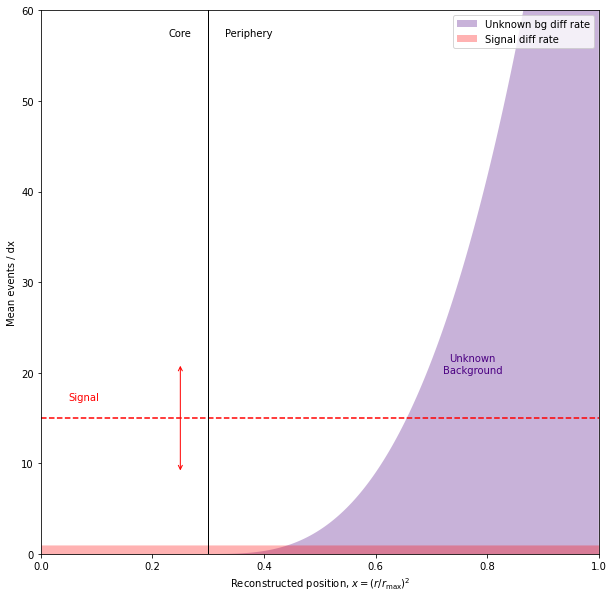

In [8]:
# Example experiment, shifted to periphery
# See cylinder.ipynb notebook

# `similarity` controls shape of background
# 0.5: straight line, y=x
# < 0.5: convex (like right side of happy parabola)
# > 0.5: concave (like log)
similarity = 0.25

mu_unknown = 20
background = common.powerlaw(mu=mu_unknown, alpha=similarity)
scale = 1 - f_core
background = background(loc=f_core, scale=1-f_core)
assert background.min() == f_core
assert background.max() == 1
signal = hp.uniform()
# x = np.linspace(0, 1.1, 1000)
# signal(rate=10).plot_diff_rate(x)
# background.plot_diff_rate(x)

rs = np.linspace(0, 1, 1000)

plt.figure(figsize=(10, 10), facecolor='w')

#plt.scatter(data, 0 * data, c='k', clip_on=False, s=10)
#plt.text(0.6, 4, "Example dataset", c='k')

# Background and signal dist
c = 'indigo'
plt.fill_between(rs, 0, background.diff_rate(rs), 
                 color=c, alpha=0.3, linewidth=0, label='Unknown bg diff rate')
plt.fill_between(rs, 0, signal.diff_rate(rs), 
                 color='r', alpha=0.3, linewidth=0, label='Signal diff rate')
plt.text(0.72, 20, 'Unknown\nBackground', c='indigo', ma='center')
plt.legend()

# Signal marker (Horizontal red dotted line, red double-headed arrow, and text saying 'Signal')
mu_sig = 15
y_text = mu_sig + 2
plt.axhline(mu_sig, linestyle='--', c='r')
plt.text(0.05, y_text, 'Signal', c='r')
arrow_x = 0.25
sig_amp = 0.4
plt.annotate("", xy=(arrow_x, mu_sig * (1 - sig_amp)), 
             xytext=(arrow_x, mu_sig * (1 + sig_amp)),
             arrowprops=dict(arrowstyle='<->', color='r'))

# Core marker (vertical thin black line and text saying 'Core' and 'Periphery')
plt.axvline(f_core, c='k', linewidth=1)
plt.text(f_core - 0.03, 58, "Core", ha='right', va='top')
plt.text(f_core + .03, 58, "Periphery", ha='left', va='top')

# Axes labels
plt.ylabel("Mean events / dx")
plt.ylim(0, 60)

plt.xlabel("Reconstructed position, $x = (r / r_\mathrm{max})^2$")
plt.xlim(0, 1)

# Save plots
for fmt in ('png', 'pdf'):
    plt.savefig(f'example_experiment_core.{fmt}', dpi=200, bbox_inches='tight')

## Find $\alpha_\text{lower}$, the false discovery probability (step 2)

For a simple procedure like Feldman-Cousins counting, this is easy to compute.

Text(0.5, 0, 'Expected signal events in the full experiment')

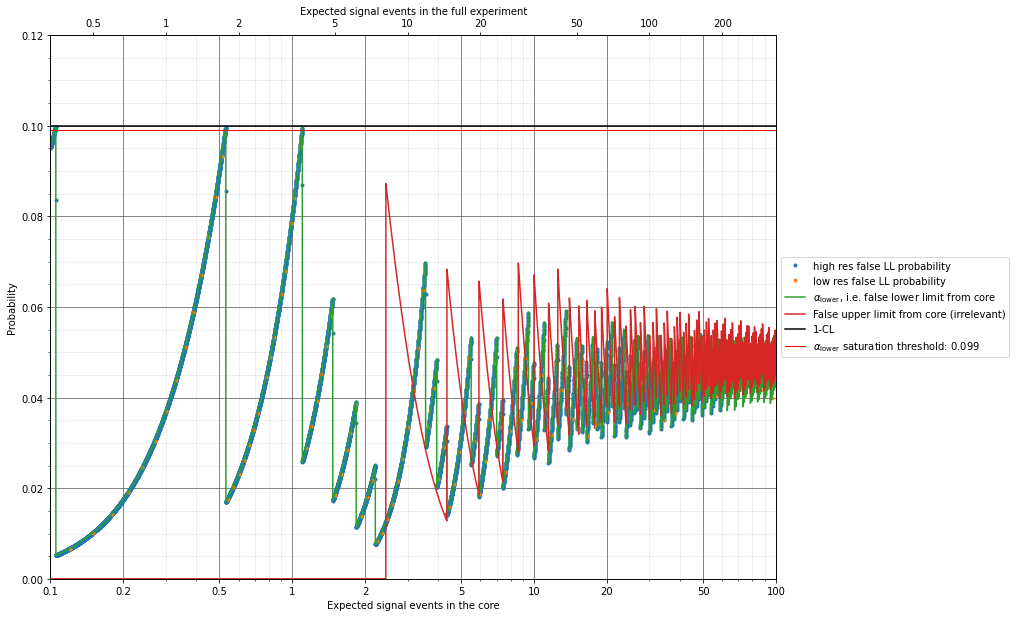

In [9]:
# Threshold above which alpha (probability of FC LL screwing up) is considered saturated
saturation_threshold = 0.099

# P(False discovery | mu in core)
fc_limit_info = fc_limits(mu_bg=0)  # no known background
false_lower_core = fc_limit_info['false_lower'] # probability of FC LL screwing up, P(mu<LL)

# Computation in the 'full space' (core+peripheral), which is why need to scale mu by `f_core` 
# when sending things in for interpolation. mu is signal-only expectation in core region.

# `mu_full` is just some ndarray of mu's from [0.1, 1250], 152 elements, I think logspaced
mu_full = hp.DEFAULT_RATE_GRID
alpha_lower = np.interp(x=mu_full, xp=mu / f_core, fp=false_lower_core)

# High res version for determining which hypotheses can never be excluded
# `mu` is np.concatenate([np.array([0]), np.geomspace(0.1, 200, 10_000)])
alpha_lower_hr = np.interp(x=mu, xp=mu / f_core, fp=false_lower_core)

# Plot things
plt.figure(figsize=(13, 10), facecolor='w')
plt.plot(mu*f_core, alpha_lower_hr, '.', label='high res false LL probability')
plt.plot(mu_full*f_core, alpha_lower, '.', label='low res false LL probability')

plt.plot(mu, false_lower_core, label=r'$\alpha_\mathrm{lower}$, i.e. false lower limit from core')
plt.plot(mu, fc_limit_info['false_upper'], label='False upper limit from core (irrelevant)')
plt.axhline(1 - confidence_level, c='k', label='1-CL')
plt.axhline(saturation_threshold, c='r', lw=1,\
            label=fr'$\alpha_\mathrm{{lower}}$ saturation threshold: {saturation_threshold:.3f}')
plt.ylim(0, 0.12)

# x axis in terms of signal expecation in core region
common.log_x(0.1, 100)
plt.xlabel("Expected signal events in the core")
plt.ylabel("Probability")
plt.minorticks_on()
plt.grid(which='major', color='#666666', linestyle='-')
plt.grid(which='minor', color='#999999', linestyle='-', alpha=0.2)
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

# x axis in terms of signal expecation in full experiment
plt.twiny()
common.log_x(0.1 / f_core, 100 / f_core)
plt.xlabel("Expected signal events in the full experiment")

In [10]:
mu[np.where(alpha_lower_hr > saturation_threshold)[0]]

array([0.34761053, 0.34787487, 0.34813942, 0.34840416, 0.34866911,
       0.34893425, 0.3491996 , 0.34946515, 0.34973091, 0.34999686,
       0.35026302, 0.35052938, 1.76304521, 1.76438593, 1.76572767,
       1.76707042, 1.7684142 , 1.769759  , 3.65758159, 3.66036301,
       3.66314656, 3.66593222])

In [11]:
# Deficit hawk cannot exclude this hypothesis, because alpha is saturated
mu_never_exclude = mu[np.where(alpha_lower_hr > saturation_threshold)[0][-1]]
mu_never_exclude, mu_never_exclude * f_core

(3.665932215167418, 1.0997796645502254)

## Setup deficit hawk with modified critical value (step 3)

In [12]:
signal = hp.uniform().fix_except('rate')
stat = hp.FixedRegionSimpleHawk(
    signal, 
    signal_only=True, 
    # Test 100 options for [0, between 0.3 and 1.0] # core is from [0, 0.3]
    # This is a fine approximation to testing _all_ options
    # (probably better than other approximations we make, e.g. using MC with 10k toys)
    # but much easier to code!
    cuts = [(0, x) for x in np.linspace(f_core, 1, 100)],
    ).with_stored_dist(f'lr_oneside_{f_core=:.2f}')
ul = hp.UpperLimit(stat, anchors=hp.DEFAULT_RATE_GRID.tolist())

Because $\alpha_\text{lower}$ is jagged, the critical value will also be (and there is also some wigglyness from finite toys)

 99%|███████████████████████████████████████▋| 151/152 [00:01<00:00, 117.17it/s]


Text(0, 0.5, 'Deficit Hawk test statistic, $t$')

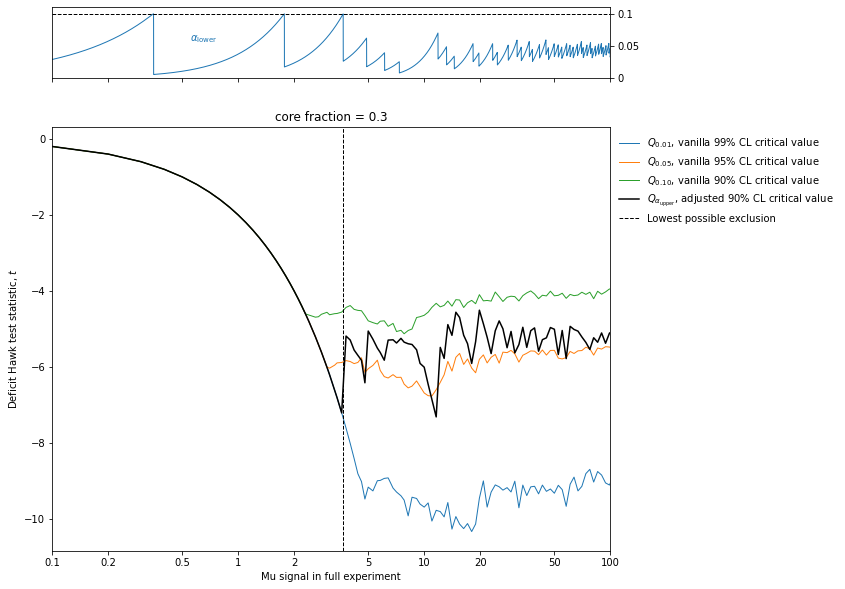

In [13]:
# `alpha_lower` is false exclusion by LL
# alpha_upper = alpha_total - alpha_lower
alpha_upper = (1 - confidence_level) - alpha_lower
    
# `mu_full` is just some ndarray of mu's from [0.1, 1250], 152 elements, I think logspaced
# Inverse CDF of test statistic from the FixedRegionSimpleHawk
# `original_critical_t` is the unadjusted critical value for the DH test statistic
orig_critical_t = stat.dist(quantiles=1 - confidence_level).ppf(rate=mu_full)

# adjusted critical value
critical_t = np.array([
    stat.dist(quantiles=alpha).ppf(rate=mu)
    for alpha, mu in zip(alpha_upper, tqdm(mu_full))],
)

# start of complicated plot with shared x axis (signal expectation in full region)
f, axes = plt.subplots(
    2, 1, 
    figsize=(10, 10),
    facecolor='w',
    sharex=True, 
    gridspec_kw=dict(height_ratios=[1,6]))
plt.title(f'core fraction = {f_core}')

# top plot: probability LL screwed up, high res version
ax = axes[0]
plt.sca(ax)
common.log_x(0.1, 100)

plt.plot(mu,
         alpha_lower_hr, 
         c='C0', linewidth=1)
plt.text(0.65, 0.06, r"$\alpha_\mathrm{lower}$", 
         c='C0',
         ha='center', va='center')
plt.axhline(1-confidence_level, linewidth=1, c='k', linestyle='--')

plt.ylim(0, 0.11)
plt.yticks([0, .05, .1])
ax.yaxis.set_major_formatter(matplotlib.ticker.FormatStrFormatter('%g'))
ax.yaxis.tick_right()

# bottom plot: critical values (inverse CDF) of different flavours
ax = axes[1]
plt.sca(ax)

# for 99, 95, 90% CL UL 1-sided
for alpha in [0.01, 0.05, 0.1]:
    y = stat.dist(quantiles=alpha).ppf(rate=mu_full)
    plt.plot(mu_full, 
             stat.dist(quantiles=alpha).ppf(rate=mu_full), 
             label=f'$Q_{{{alpha:.2f}}}$, vanilla {(1.-alpha)*100.:.0f}% CL critical value',
             linewidth=1)

# adjusted 90% CL critical value
plt.plot(mu_full, 
         critical_t,
         label=fr'$Q_{{\alpha_\mathrm{{upper}}}}$, adjusted {confidence_level*100.:.0f}% CL critical value',
         c='k')

# vertical dotted line
plt.axvline(
    mu_never_exclude, 
    c='k', linestyle='--', linewidth=1,
    label='Lowest possible exclusion')

plt.legend(loc='upper left', bbox_to_anchor=(1,1), frameon=False)

plt.xlabel("Mu signal in full experiment")
plt.ylabel("Deficit Hawk test statistic, $t$")

So now the DH-adjusted 90% CL critical value (thick black line) is between the original 90% (green) and 95% (orange) CL critical values. Which really means that even though the UL that you'll be drawing with the DH portion is still worth 90% CL, the location of this UL is somewhere between UL you would get from using 90 and 95% CL. I.e. the price you pay for being able to claim discovery (having LL) is that your UL weakens to what you would get from setting a 90-95% CL UL.

The vertical dotted line marks the largest signal expectation in the full experiment below which Jelle doesn't dare to exclude. Actually not sure why. 

Suppose $\alpha_{LL}\gt(1-CL)$,
\begin{align}
\alpha_{LL}&\gt 1-CL=\alpha\\
0 &\gt \alpha-\alpha_{LL}=\alpha_{UL}
\end{align}

But then if you see $\alpha_{UL}\lt0$, it already doesn't make sense, then you can say, ok, let's not do this combination thing. But then you'll get pockets of phase space where you can't do this combination thing, which is annoying.

This is almost like an in-built PCL..
Ok, not quite...maybe? It's similar in the sense that it gives you this minimum UL (smallest mu that one can reject with the UL), but the way of picking this minimum UL is rather inherit (like based on how much 'coverage' is left after considering the probability that the LL screws up), nothing to do with rejection power.

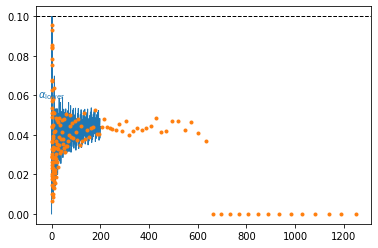

In [14]:
plt.plot(mu,
         alpha_lower_hr, 
         linewidth=1)
plt.text(0.65, 0.06, r"$\alpha_\mathrm{lower}$", 
         c='C0',
         ha='center', va='center')
plt.axhline(0.1, linewidth=1, c='k', linestyle='--')
plt.plot(mu_full, alpha_lower, '.')

In [15]:
bb = []
for this_alpha, this_mu in zip(alpha_upper, tqdm(mu_full)):
    aa = stat.dist(quantiles=this_alpha).ppf(rate=this_mu)
    bb.append(aa)
    print(this_alpha, this_mu, aa)
bb = np.asarray(bb)

 16%|██████▍                                  | 24/152 [00:00<00:01, 116.49it/s]

0.07145122541078784 0.1 -0.2
0.042902450821575705 0.2 -0.4000000000000001
0.014353676232363582 0.3 -0.6
0.09335088869646666 0.4 -0.8
0.08981417175724841 0.5 -1.0
0.08561884831468373 0.6 -1.2
0.08080693746531406 0.7 -1.4
0.07541854555989763 0.8 -1.6
0.0694919550551515 0.9 -1.8
0.06306368452484543 1.0 -2.0
0.05616856184928016 1.1 -2.2
0.04883980235891904 1.2 -2.4
0.04110905133616225 1.3 -2.6
0.0330064817449674 1.4 -2.7999999999999994
0.024560814999820074 1.5 -3.0
0.01579941452429591 1.6 -3.2
0.006748319661716365 1.7 -3.4
0.08239699904334492 1.8 -3.6
0.0797445410271666 1.9 -3.7999999999999994
0.07688471083996055 2.0 -4.0
0.07381747365944484 2.1 -4.2
0.07054342880952966 2.2 -4.4
0.06706373765984355 2.3 -4.6
0.06338006216068344 2.4 -4.8
0.05540980255294091 2.6 -5.2


 32%|████████████▉                            | 48/152 [00:00<00:00, 116.35it/s]

0.051128783326893815 2.7 -5.4
0.04665482664358411 2.8 -5.6
0.03714305403275428 3.0 -6.0
0.03211340118098541 3.1 -6.2
0.0215287652636999 3.3 -6.599999999999999
0.015983261937710894 3.4 -6.8
0.004410792027355684 3.6 -7.2
0.07120208740089409 3.8 -5.181818181818181
0.06623102689566843 4.0 -5.284848484848485
0.060791779411583105 4.2 -5.54909090909091
0.054882603448152587 4.4 -5.688888888888889
0.04850446655952794 4.6 -5.817373737373736
0.04166083287905879 4.8 -6.409696969696969
0.08142405118465867 5.0 -5.050505050505049
0.07686490026734455 5.3 -5.2645863588838475
0.07163950482029821 5.6 -5.498181818181817
0.067773089732247 5.8 -5.611666357840351
0.06138443715768992 6.1 -5.816565656565656
0.0861534464062292 6.4 -5.288080808080808
0.08194912312431177 6.8 -5.279996463708203
0.07827455097412656 7.1 -5.364444444444444
0.09162792205490487 7.5 -5.242424242424243
0.08978665449630527 7.8 -5.341818181818182
0.08689515039159507 8.2 -5.383838383838383


 47%|███████████████████▍                     | 72/152 [00:00<00:00, 111.42it/s]

0.08345893659540048 8.6 -5.403232323232323
0.07832566530797569 9.1 -5.542027250871831
0.07349578350279182 9.5 -5.900690211976076
0.06649143820657466 10.0 -6.0
0.058354059268672515 10.5 -6.448484848484848
0.04903431584587073 11.0 -6.84417119549226
0.03624281023335314 11.6 -7.306032496804924
0.06658890605358624 12.2 -5.480019606948893
0.05782688439939111 12.8 -5.769073623428392
0.07803515923985693 13.4 -4.880833321958921
0.07097272017315259 14.1 -5.162701153953307
0.0842559089327099 14.8 -4.555676877229375
0.07916478766969942 15.5 -4.693932872160901
0.07198792670762164 16.3 -5.1604920565866355
0.06320862762234064 17.1 -5.38130349851794
0.05124499192664521 18.0 -5.90164136555342
0.06955422098450569 18.9 -5.329541152159701
0.08122627968424248 19.8 -4.502465540042772
0.07394044968606837 20.8 -4.856400864622442
0.0647836695277308 21.8 -5.213599199386514
0.05230621280813537 22.9 -5.641736744404918
0.06642798284094939 24.1 -5.0433693657691165
0.07647272461100169 25.3 -4.783362037800328


 63%|█████████████████████████▉               | 96/152 [00:00<00:00, 112.52it/s]

0.06727702946551395 26.5 -4.991121761750332
0.05354940928698054 27.9 -5.488276468273792
0.06494459065595201 29.3 -5.060232707433151
0.05132959671521962 30.7 -5.624064608488556
0.06120613756680923 32.3 -5.405029968963132
0.06907786161035681 33.9 -4.950932981892995
0.05497522061889484 35.6 -5.479073334279339
0.06226811359772476 37.4 -5.040744702721073
0.06835493278536547 39.2 -4.967339699636195
0.05253364680791129 41.2 -5.579524921037812
0.05840778329783154 43.2 -5.277018261658739
0.06209550492827554 45.4 -5.227970075377534
0.0647744658533457 47.7 -4.957729354913498
0.06664053356824676 50.1 -5.002640048454152
0.05194730034989578 52.6 -5.664863818123489
0.06844516381793989 55.2 -5.035426364862227
0.04952722133895505 58.0 -5.7738999822407635
0.06578200959173085 60.9 -4.926687461653579
0.06568608208342025 63.9 -5.008233681303446
0.06324519281681903 67.1 -5.051795742122394
0.06025442453247951 70.4 -5.204556713427696
0.055400044264298884 74.0 -5.349281555415413
0.04971589795683736 77.7 -5.532

 79%|███████████████████████████████▌        | 120/152 [00:01<00:00, 112.63it/s]

0.05393154596637621 85.6 -5.343961974739219
0.06171148240885854 89.9 -5.100394311455107
0.05278331582723446 94.4 -5.370882691084831
0.05856585942409742 99.1 -5.105049296889623
0.06269506069338995 104.0 -5.041036027418696
0.052072625560746585 109.0 -5.300907425004615
0.06497866858783173 115.0 -4.816920988787075
0.055481340359820885 120.0 -5.24411708899421
0.06331627376026669 127.0 -5.108794568775877
0.04912010916616737 133.0 -5.309799976231913
0.06202775662876648 139.0 -4.893983609429863
0.05737754325289318 146.0 -5.167439125906659
0.06085348339591012 154.0 -4.917931866364121
0.056504710432988145 161.0 -5.3181755330115195
0.05616351257024207 170.0 -5.089925731676679
0.047449113347841555 178.0 -5.463665366762993
0.05955836807356698 187.0 -4.989400931297812
0.059438939353396586 196.0 -4.933116068553424
0.05582336917555011 206.0 -5.107475603110901
0.052215125586199465 216.0 -5.245352860956134
0.05617262296235472 227.0 -5.037913261466479
0.05649983662347216 239.0 -5.210645569317741
0.057197

 95%|█████████████████████████████████████▉  | 144/152 [00:01<00:00, 114.47it/s]

0.054729848467205945 276.0 -5.17398957766585
0.05823334831622151 290.0 -5.005595563573346
0.05317237546664229 304.0 -5.226157802330022
0.06012220862502386 320.0 -4.984396090551861
0.0582710047964754 336.0 -4.979606182438276
0.05652046434172062 352.0 -5.217384661299369
0.057797494623064175 370.0 -5.006191700537518
0.05650471901838966 389.0 -5.1448527383195
0.055331112529202545 408.0 -5.266035485878918
0.05170456300161204 428.0 -5.388665255899533
0.05837656571849319 450.0 -5.081511052960765
0.05812186730001986 472.0 -5.068162389637173
0.052845852467976184 496.0 -5.251774331145423
0.052782398195423914 521.0 -5.237525536471713
0.05762066115846369 547.0 -5.112657438081846
0.053315977697051986 574.0 -5.297948098433225
0.059050400133257006 603.0 -4.891701797197897
0.06313817699007232 633.0 -4.920635513583599
0.09999999999999998 665.0 -3.9448916686305466
0.09999999999999998 698.0 -3.858383628523015
0.09999999999999998 733.0 -3.927345113454585
0.09999999999999998 769.0 -3.873666779593563
0.0999

 99%|███████████████████████████████████████▋| 151/152 [00:01<00:00, 112.74it/s]

0.09999999999999998 891.0 -3.87211856143415
0.09999999999999998 935.0 -3.8400451290511626
0.09999999999999998 982.0 -3.9085537252330362
0.09999999999999998 1030.0 -3.809259718405686
0.09999999999999998 1080.0 -3.79347193239596
0.09999999999999998 1140.0 -3.8970039452172784
0.09999999999999998 1190.0 -3.853309150314061
0.09999999999999998 1250.0 -3.8786970163208423


/tmp/ipykernel_32740/2839076000.py:7: UserWarning: Attempt to set non-positive xlim on a log-scaled axis will be ignored.
  plt.xlim(0, 100)


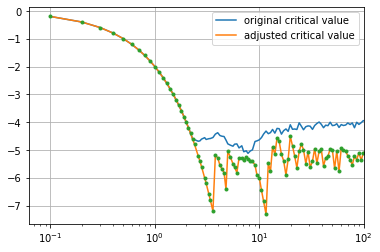

In [16]:
plt.plot(mu_full, orig_critical_t, label='original critical value')
plt.plot(mu_full, critical_t, label='adjusted critical value')
plt.plot(mu_full, bb, '.')

plt.legend()
plt.xscale('log')
plt.xlim(0, 100)
plt.grid()

Make the deficit hawk use this modified critical value. My apologies for this ugly hack. Hypney should allow this in a simpler way...

In [17]:
# `ul` and `ul_orig` are hypney upper limit classes
ul = hp.UpperLimit(stat, anchors=mu_full.tolist())
ul_orig = hp.UpperLimit(stat, anchors=mu_full.tolist())

# Then the aforementioned 'ugly hack' to adjust the critical values
# `critical_t` is the adjusted DH test statistic critical values.
def modified_ppf(*, params):
    return np.interp(x=params['rate'], xp=mu_full, fp=critical_t)
ul._ppf_pre_fudge = modified_ppf
ul.crit_at_anchors = critical_t

Test with some example data

In [18]:
# Just some example dataset
#data = np.array([0., 0.1, 0.1, 0.5, 0.7])
data = np.array([0., 0.5, 0.7])

# Limit with modified PPF
this_modified_ul = ul(data=data)

# Limit with original PPF (if you do only deficit hawk, so no discovery ability)
this_original_ul = ul_orig(data=data)

# lower limit for fun
ll = hp.LowerLimit(stat, anchors=mu_full.tolist())
this_ll = ll(data=data)

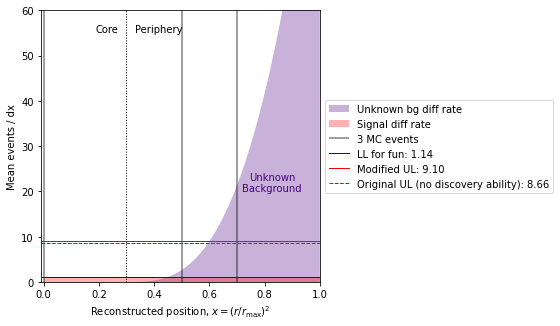

In [19]:
# Keeping the same config as the above cells that plotted the plot with core+periphery distributions

max_y = 60

rs = np.linspace(0, 1, 1000)
plt.figure(figsize=(5, 5), facecolor='w')
# Background and signal dist
c = 'indigo'
plt.fill_between(rs, 0, background.diff_rate(rs), 
                 color=c, alpha=0.3, linewidth=0, label='Unknown bg diff rate')
plt.fill_between(rs, 0, signal.diff_rate(rs), 
                 color='r', alpha=0.3, linewidth=0, label='Signal diff rate')
plt.text(0.72, 20, 'Unknown\nBackground', c='indigo', ma='center')

# Core marker (vertical thin dotted black line and text saying 'Core' and 'Periphery')
plt.axvline(f_core, c='k', ls=':', linewidth=1)
plt.text(f_core - 0.03, 0.95*max_y, "Core", ha='right', va='top')
plt.text(f_core + .03, 0.95*max_y, "Periphery", ha='left', va='top')

# Location of MC events
plt.vlines(x=data, ymin=0, ymax=max_y, color='k', alpha=0.5, label=f'{len(data)} MC events')

# There is only 1 LL
plt.axhline(this_ll, c='b', lw=1, label=f'LL for fun: {this_ll:.2f}')

# Location of original UL and modified UL
plt.axhline(this_modified_ul, c='r', lw=1, label=f'Modified UL: {this_modified_ul:.2f}')

# Limit with original PPF (if you do only deficit hawk, so no discovery ability)
plt.axhline(this_original_ul, c='r', ls='--', lw=1,\
            label=f'Original UL (no discovery ability): {this_original_ul:.2f}')


# Axes labels
plt.ylabel("Mean events / dx")
plt.ylim(0, max_y)
plt.xlabel("Reconstructed position, $x = (r / r_\mathrm{max})^2$")
plt.xlim(-0.01, 1)
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

## Combined procedure

In [20]:
f_core

0.3

In [21]:
1/0.3, 1/.8

(3.3333333333333335, 1.25)

Text(0.5, 0, 'n')

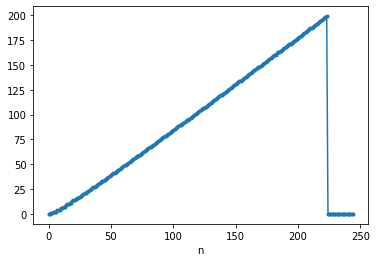

In [22]:
plt.plot(fc_limit_info['n'], fc_limit_info['lower'], '.-')
plt.xlabel('n')

In [23]:
def combined_procedure(data, f_core=f_core):
    n_core = np.sum(data < f_core).astype(int)
    lower = fc_limit_info['lower'][n_core] / f_core
    upper = max(mu_never_exclude, ul(data)) # ul(data) is the DH UL with the modified crit value
    upper_coreonly = fc_limit_info['upper'][n_core] / f_core
    return (lower, upper, upper_coreonly)


In [24]:
def combined_procedure(data, f_core=f_core):
    n_core = np.sum(data < f_core).astype(int)
    lower = fc_limit_info['lower'][n_core] / f_core
    upper = max(mu_never_exclude, ul(data)) # ul(data) is the DH UL with the modified crit value
    upper_coreonly = fc_limit_info['upper'][n_core] / f_core
    return (lower, upper, upper_coreonly)

# Test on some example data again
print(f'f_core = {f_core}:\n(FC LL, DH UL with modified threshold, FC UL) = {combined_procedure(data)}\n')
print(f'f_core = 1.:\n(FC LL, DH UL with modified threshold, FC UL) = {combined_procedure(data, f_core=1.)}')

f_core = 0.3:
(FC LL, DH UL with modified threshold, FC UL) = (0.3510168739245596, 9.100000000412683, 14.532294376943094)

f_core = 1.:
(FC LL, DH UL with modified threshold, FC UL) = (1.1013091755424596, 9.100000000412683, 7.428152079153028)


In the first case (f_core=0.3), the modified UL is better (smaller number) than the original FC UL because of the gain in exposure by including the peripheral region.

In the second case (f_core=1.), ie. there is no peripheral region, then the modified UL is lousier (larger number) than the original FC region because this modified DH approach is supposedly conservative by construction. But yeah, you can see that there's a minimum value of mu (mu_never_exclude) below which the UL is not allowed to exist.

This really shows that you have to understand how much you gain in exposure you get by including the peripheral region. Else the UL from this DH with modified critical threshold approach is just gonna whammy you.

A (crazy) example that gives an empty interval (lower limit > upper limit)

In [25]:
combined_procedure(np.ones(13) * 0.1)

(24.74169198064821, 23.309678320908155, 66.87246022613667)

In [26]:
weird_events = np.ones(13) * 0.1 # just a pile of events at low r

num_tests = 100
test_f_core = np.geomspace(0.01, 1, num_tests) # core can't be zero.

lower_bag = np.zeros(num_tests)
fc_upper_bag = np.zeros(num_tests)
dh_upper_bag = np.zeros(num_tests)

for ind, this_test in enumerate(test_f_core):
    tmp = combined_procedure(weird_events, f_core=this_test)
    lower_bag[ind] = tmp[0]
    dh_upper_bag[ind] = tmp[1]
    fc_upper_bag[ind] = tmp[2]

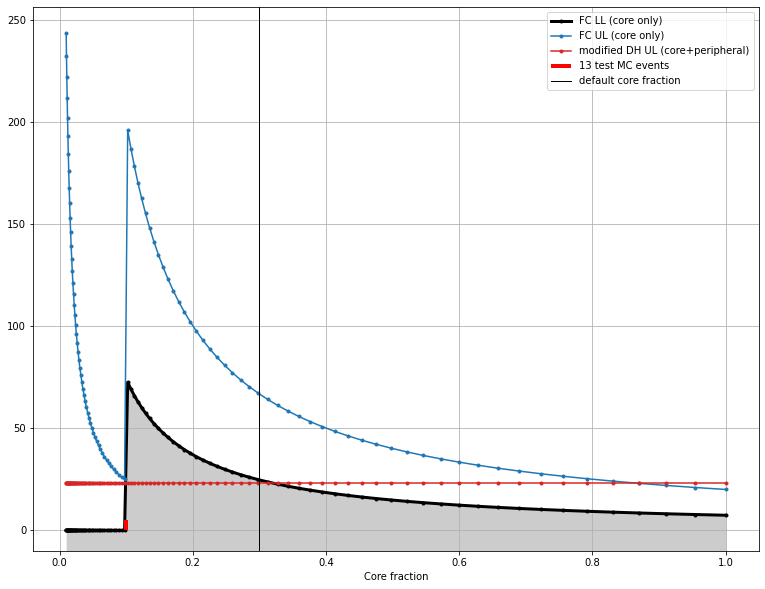

In [27]:
min_y = -10
plt.figure(figsize=(13, 10), facecolor='w')
plt.plot(test_f_core, lower_bag, '.-', c='k', lw=3, label='FC LL (core only)')
plt.fill_between(test_f_core, min_y, lower_bag, 
                 alpha=0.2, linewidth=0,
                 color='k')

plt.plot(test_f_core, fc_upper_bag, '.-', c='tab:blue', label='FC UL (core only)')
plt.plot(test_f_core, dh_upper_bag, '.-', c='tab:red', label='modified DH UL (core+peripheral)')

plt.vlines(weird_events, ymin=0, ymax=5, color='r', lw=4, label=f'{len(weird_events)} test MC events')
plt.axvline(f_core, c='k', lw=1, label='default core fraction')
plt.grid()
plt.xlabel('Core fraction')
plt.ylim(min_y)
plt.legend()

To have non-empty intervals, the UL must be above the FC LL (thick black). Essentially, no coloured lines should go into the shaded region.

The FC intervals are always safe (as expected, else smt must have screwed up) since the FC UL (blue) are always above the FC LL (thick black).

But the modified DH UL (red) can give empty intervals; the red line goes into the shaded region for some core fraction. So this DH combination method can indeed be secretly dangerous.

The discontinuity in the FC UL coincides with the location of the weird test events.

NEED MOAR BRAINS TO THINK ABOUT WHEN THIS MODIFIED DH UL THING IS DANGEROUS. I DON'T WANT EMPTY INTERVALS.
TRADEOFF BETWEEN:
- AM I ADDING ENOUGH PERIPHERAL REGION?
- AM I GONNA GET EMPTY INTERVAL?

Find mean upper/lower limits with MC

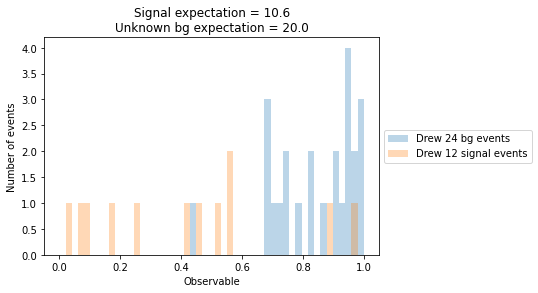

In [28]:
my_sig_rate = 10.6
test_bg = background.simulate()
test_sig = signal(rate=my_sig_rate).simulate()

bin_edges = np.linspace(0, 1., 50)
plt.hist(test_bg, bins=bin_edges, alpha=0.3, label=f'Drew {len(test_bg)} bg events')
plt.hist(test_sig, bins=bin_edges, alpha=0.3, label=f'Drew {len(test_sig)} signal events')

plt.xlabel('Observable')
plt.ylabel('Number of events')
plt.title(f'Signal expectation = {my_sig_rate:.1f}\nUnknown bg expectation = {mu_unknown:.1f}')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

In [29]:
num_test_toys = 1000
aa = [len(background.simulate()) for _ in range(num_test_toys)]
bb = [len(signal(rate=my_sig_rate).simulate()) for _ in range(num_test_toys)]

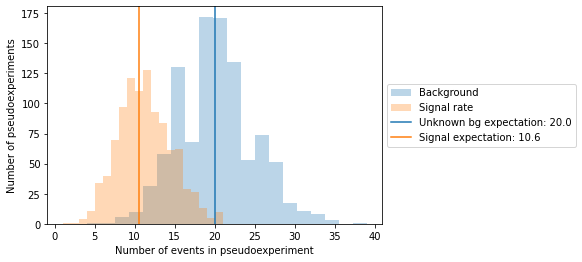

In [30]:
plt.hist(aa, color='C0', alpha=0.3, bins=20, label='Background')
plt.hist(bb, color='C1', alpha=0.3, bins=20, label='Signal rate')
plt.axvline(mu_unknown, color='C0', label=f'Unknown bg expectation: {mu_unknown:.1f}')
plt.axvline(my_sig_rate, color='C1', label=f'Signal expectation: {my_sig_rate:.1f}')
plt.xlabel('Number of events in pseudoexperiment')
plt.ylabel('Number of pseudoexperiments')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

In [31]:
mu_sigs = mu_full[mu_full < 30]
n_trials = 10_000

# n_trials pseudoexperiments per test signal strength
def draw_results(mu_sig):
    return np.asarray([
        combined_procedure(
            (background + signal(rate=mu_sig)).simulate())
        for _ in range(n_trials)])

cache_fn = Path(f'discovery_{f_core=:0.3f}_{n_trials=:07d}_{mu_unknown=:0.2f}.pkl')
if cache_fn.exists():
    # Load results from cache
    with open(cache_fn, mode='rb') as f:
        results = pickle.load(f)
else:
    # Do computation (test multiple signal strengths)
    with ProcessPoolExecutor(max_workers=7) as exc:
        results = np.stack(list(tqdm(
            exc.map(draw_results, mu_sigs), 
            total=len(mu_sigs))))
    
    # Dump results to cache
    with open(cache_fn, mode='wb') as f:
        pickle.dump(results, f)

In [32]:
# number of signal strength tested,
# number of pseduoexperiments per signal strength,
# [LL, modified UL, coreonly UL]
np.shape(results)

(75, 10000, 3)

In [33]:
result_types = ['lower', 'upper', 'upper_core']

quantiles = {
    result_name: {
        n_sigma: np.quantile(results[...,i], stats.norm.cdf(n_sigma), axis=1)
        for n_sigma in [-2, -1, 0, 1, 2]}
    for i, result_name in enumerate(result_types)
}
means = {
    result_name: np.mean(results[...,i], axis=1)
    for i, result_name in enumerate(result_types)
}

# weird case 1: LL >= modified UL. ie. modified UL gave empty interval
p_empty = np.mean(results[...,0] >= results[...,1], axis=1)

# weird case 2: modified UL >= FC core-only UL. ie. all this work for lousier results
p_worse = np.mean(results[...,1] >= results[...,2], axis=1)

# weird case 3: modified UL = mu threshold below which cannot exclude with this method.
# ie. modified UL was so low that it got caught by the threshold
p_clipped = np.mean(results[...,1] == mu_never_exclude, axis=1)

Probability of 'peculiar features'. (1) and (3) should be nearly impossible, and (2) should be really rare at 0 signal.

Text(0.5, 0, 'Signal expectation (in core+peripheral)')

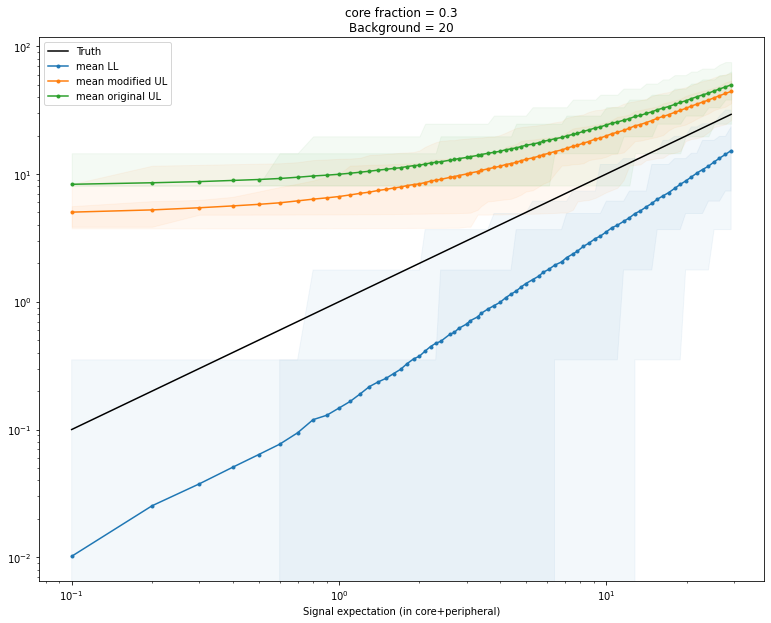

In [34]:
ls_bag = {
    0: '-',
    1: '--',
    2: ':',
}
label_bag = {
    'lower': 'mean LL',
    'upper': 'mean modified UL',
    'upper_core': 'mean original UL'
}

plt.figure(figsize=(13, 10), facecolor='w')
plt.plot(mu_sigs, mu_sigs, c='k', label='Truth')
for ind, this_res in enumerate(result_types):
    plt.plot(mu_sigs, means[this_res], '.-', c=f'C{ind}', label=label_bag[this_res])
    
    for n_sigma in [1, 2]:
        plt.fill_between(mu_sigs, 
                 quantiles[this_res][n_sigma*-1], quantiles[this_res][n_sigma],
                 color=f'C{ind}', alpha=0.05)
        
    '''
    for n_sigma in [-2, -1, 0, 1, 2]:
        plt.plot(mu_sigs, quantiles[this_res][n_sigma],
                 c=f'C{ind}', ls=ls_bag[abs(n_sigma)])
    #'''

plt.xscale('log')
plt.yscale('log')
plt.legend()
plt.title(f'core fraction = {f_core}\nBackground = {mu_unknown}')
plt.xlabel('Signal expectation (in core+peripheral)')

Text(0.5, 1.0, 'core fraction = 0.3')

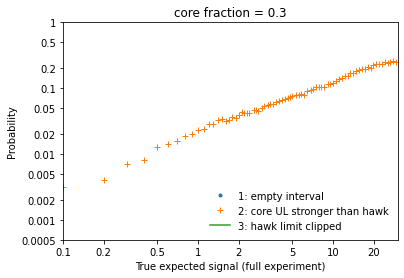

In [35]:
plt.plot(mu_sigs, p_empty, '.', label='1: empty interval')
plt.plot(mu_sigs, p_worse, '+', label='2: core UL stronger than hawk')
plt.plot(mu_sigs, p_clipped, label="3: hawk limit clipped")
plt.legend(loc='lower right', frameon=False)
common.log_y(.0005, 1)
common.log_x(0.1, 30)
plt.xlabel("True expected signal (full experiment)")
plt.ylabel("Probability")
plt.title(f'core fraction = {f_core}')

In [36]:
p_worse[-1], mu_sigs[-1]

(0.2495, 29.3)

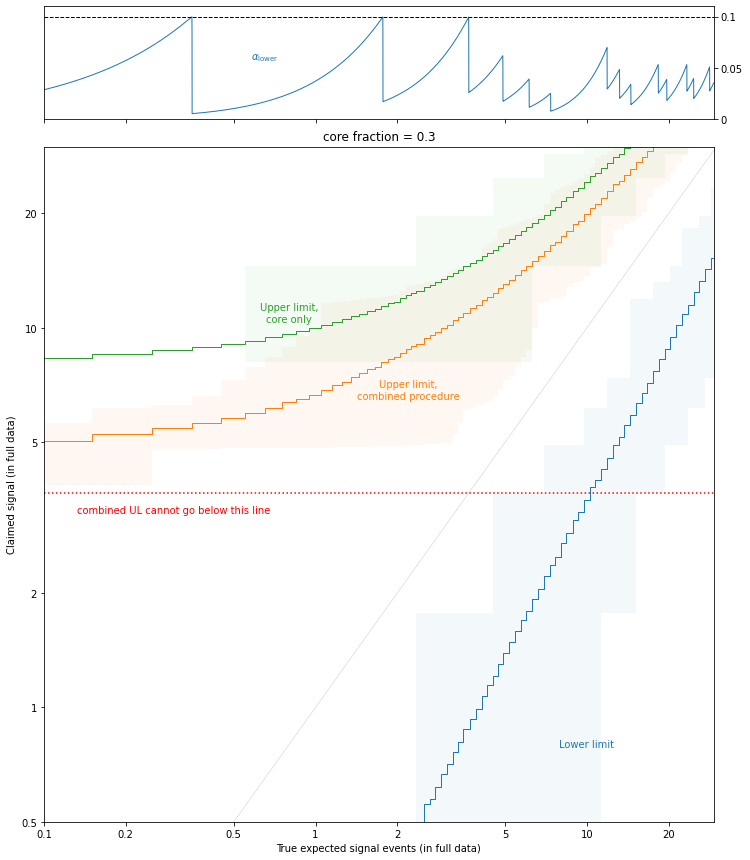

In [37]:
xlim = (mu_sigs[0], mu_sigs[-1])

f, axes = plt.subplots(
    2, 1, 
    figsize=(12, 15),
    facecolor='w',
    sharex=True, 
    gridspec_kw=dict(height_ratios=[1,6]))
plt.title(f'core fraction = {f_core}')

# top plot: how much coverage budget was used by LL
ax = axes[0]
plt.sca(ax)
plt.plot(mu,
         alpha_lower_hr, 
         c='C0', linewidth=1)
plt.text(0.65, 0.06, r"$\alpha_\mathrm{lower}$", 
         c='C0',
         ha='center', va='center')
plt.axhline(0.1, linewidth=1, c='k', linestyle='--')
plt.ylim(0, 0.11)
plt.yticks([0, .05, .1])
ax.yaxis.set_major_formatter(matplotlib.ticker.FormatStrFormatter('%g'))
ax.yaxis.tick_right()

# bottom plot:
plt.sca(axes[1])

colors = dict(lower='C0', upper='C1', upper_core='C2')
labels = dict(lower='Lower limit', upper='Upper limit,\ncombined procedure', upper_core='Upper limit,\ncore only')

for qname, q in quantiles.items():
    plt.fill_between(
        mu_sigs, q[-1], q[+1], 
        alpha=0.05, linewidth=0,
        step='mid',
        color=colors[qname])
    plt.plot(
        mu_sigs,
        means[qname],
        color=colors[qname], 
        linewidth=1,
        drawstyle='steps-mid',
        label=labels[qname]
    )
    
plt.plot([0.1, 30], [0.1, 30], c='k', linewidth=0.1, linestyle='-')

plt.axhline(mu_never_exclude, c='r', ls=':')
plt.text(0.3, 0.9*mu_never_exclude, 'combined UL cannot go below this line',
         color='r', ha='center', va='center')

blah_ind0 = np.argwhere(mu_sigs>=0.3)[1]
blah_ind = np.argwhere(mu_sigs>=1)[1]
label_locs = dict(
    lower=(10, 0.8),
    upper=(mu_sigs[blah_ind]*2., means['upper'][blah_ind]),
    upper_core=(mu_sigs[blah_ind0]*2., 2+means['upper_core'][blah_ind0]))

for qname, (x, y) in label_locs.items():
    plt.text(x, y, labels[qname], color=colors[qname], ha='center', va='center')

common.log_x(*xlim)
common.log_y(0.5, 30)

plt.xlabel("True expected signal events (in full data)")
plt.ylabel("Claimed signal (in full data)")

plt.subplots_adjust(hspace=0.07)

for fmt in 'png', 'pdf':
    plt.savefig(f'discovery_study.{fmt}', dpi=300, bbox_inches='tight')

Text(0, 0.5, 'FC UL - modified UL')

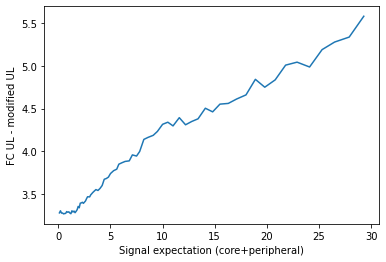

In [38]:
plt.plot(mu_sigs, means['upper_core'] -  means['upper'])

plt.xlabel('Signal expectation (core+peripheral)')
plt.ylabel('FC UL - modified UL')

### How accurately do you need to toy out p(s<LL)?

In [39]:
import scipy.stats as sps

desired_significance = [3., 5.]
p_val_threshold = 1-sps.norm.cdf(desired_significance)

for aa, bb in zip(desired_significance, p_val_threshold):
    print(f'{aa:.0f} sigmas: {bb:.1e}')

3 sigmas: 1.3e-03
5 sigmas: 2.9e-07
